In [2]:
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

# <center>Introduction to deep learning<center>
    
## Data

For this lab we are going to use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
This very standard dataset is widely used as a baseline in deep learning. Both Keras and Pytorch have datasets APIs containing this dataset.

In [3]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Task 1 - Vizualize the data:

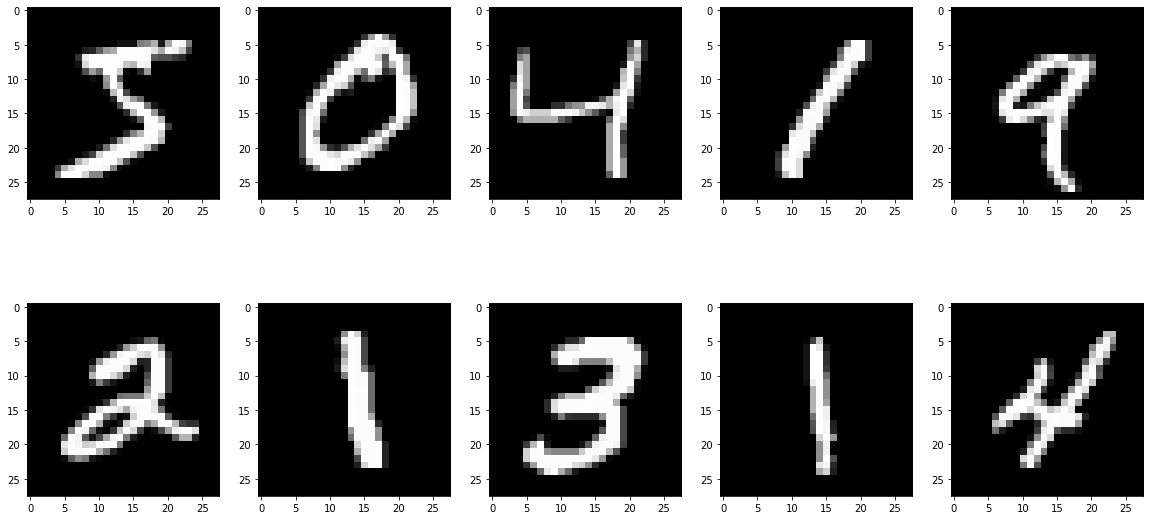

In [4]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
for _ in range(10):
    axs[_//5, _%5].imshow(x_train[_, :, :], cmap="gray")
        
plt.show()

# A first model

We are going to use Keras' Sequential API

First we need to define the layers in a list:
```python
layers = [
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
]
```
<p>The `Flatten` layer transforms the matrix into a features vector.</p>
`Dense` layers (also known as fully connected) are classical matrix multiplications.

Then the model is defined as the sequence of layers, and compiled to define the loss and the optimizer
```python 
model = keras.Sequential(layers)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```

Finally we can train the network on the training dataset while testing on the test set
```python

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))
```

`history` stores the training curves.

### Task 2 - Implement and train the model on Mnist

In [5]:
layers = [
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
]

model = keras.Sequential(layers)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.9608 - accuracy: 0.7530 - val_loss: 0.4916 - val_accuracy: 0.8771
Epoch 2/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4423 - accuracy: 0.8817 - val_loss: 0.3759 - val_accuracy: 0.9000
Epoch 3/20
60000/60000 [==============================] - 1s 25us/sample - loss: 0.3716 - accuracy: 0.8963 - val_loss: 0.3354 - val_accuracy: 0.9102
Epoch 4/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.3399 - accuracy: 0.9040 - val_loss: 0.3137 - val_accuracy: 0.9125
Epoch 5/20
60000/60000 [==============================] - 1s 25us/sample - loss: 0.3202 - accuracy: 0.9091 - val_loss: 0.2992 - val_accuracy: 0.9157
Epoch 6/20
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3061 - accuracy: 0.9130 - val_loss: 0.2883 - val_accuracy: 0.9185
Epoch 7/20
60000/60000 [==============================] 

We can now plot the training curve to evaluate the quality of the training.

### Task 3 - Complete the `plot_history` to plot the train and test losses and accuracies curves.

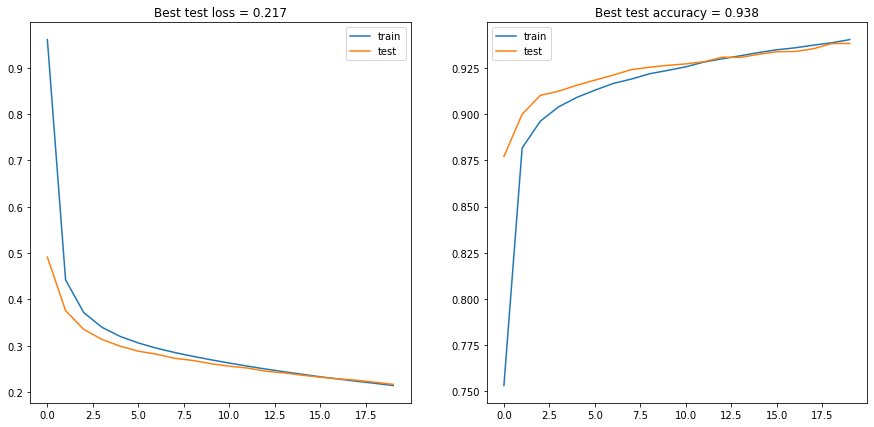

In [6]:
def plot_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,7))
    for _, (key, func) in enumerate(zip(["loss", "accuracy"], [np.min, np.max])):
        axs[_].plot(history.epoch, history.history[key], label="train")
        axs[_].plot(history.epoch, history.history["val_%s" % key], label="test")
        axs[_].set_title("Best test %s = %.3f" % (key, func(history.history["val_%s" % key])))
        axs[_].legend()

    plt.show()
    
plot_history(history)

## Activation of the Units

To understand how a neural network interprete the data, we can visualize activation of the units.
In `Keras` a model can be defined only be specifying the input and the output if the weights to link them already exist. This is usefull to acces the inner layers of a network.
```ptyhon
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.layers[1].output)
```
The previous model takes as input an image and returns the activated units of the hidden layer.

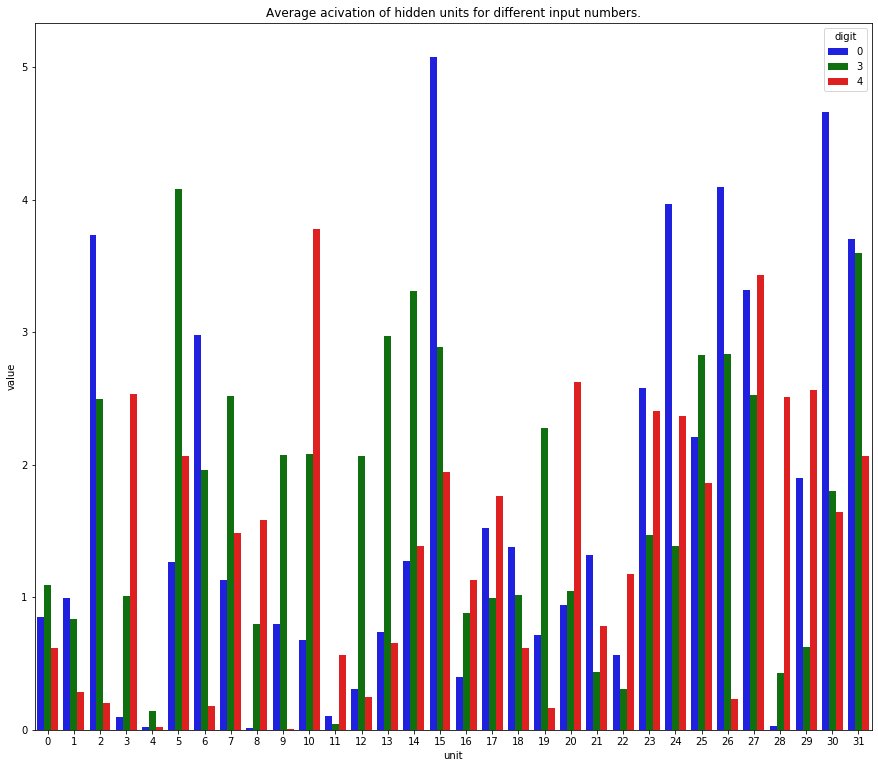

In [7]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.layers[1].output)
units = intermediate_layer_model.predict(x_test)

df = pd.concat([
    pd.DataFrame(units.reshape(-1,1), columns=["value"]), 
    pd.DataFrame(np.repeat([[_ for _ in range(32)]], 10000, axis=0).reshape(-1,1) , columns=["unit"]), 
    pd.DataFrame(y_test.reshape(-1,1).repeat(32, axis=1).reshape(-1,1), columns=["digit"])
],
    1)

plt.figure(figsize=(15,13))
sns.barplot(x="unit", y="value", hue="digit", data=df[df.digit.isin([0, 3, 4])].copy(),
            palette=["b", "g", "r"], ci=None) 
plt.title("Average acivation of hidden units for different input numbers.")
plt.show()

## Weights matrices

### Task 3 - Vizualize the weights connecting every pixel of the image to each units.

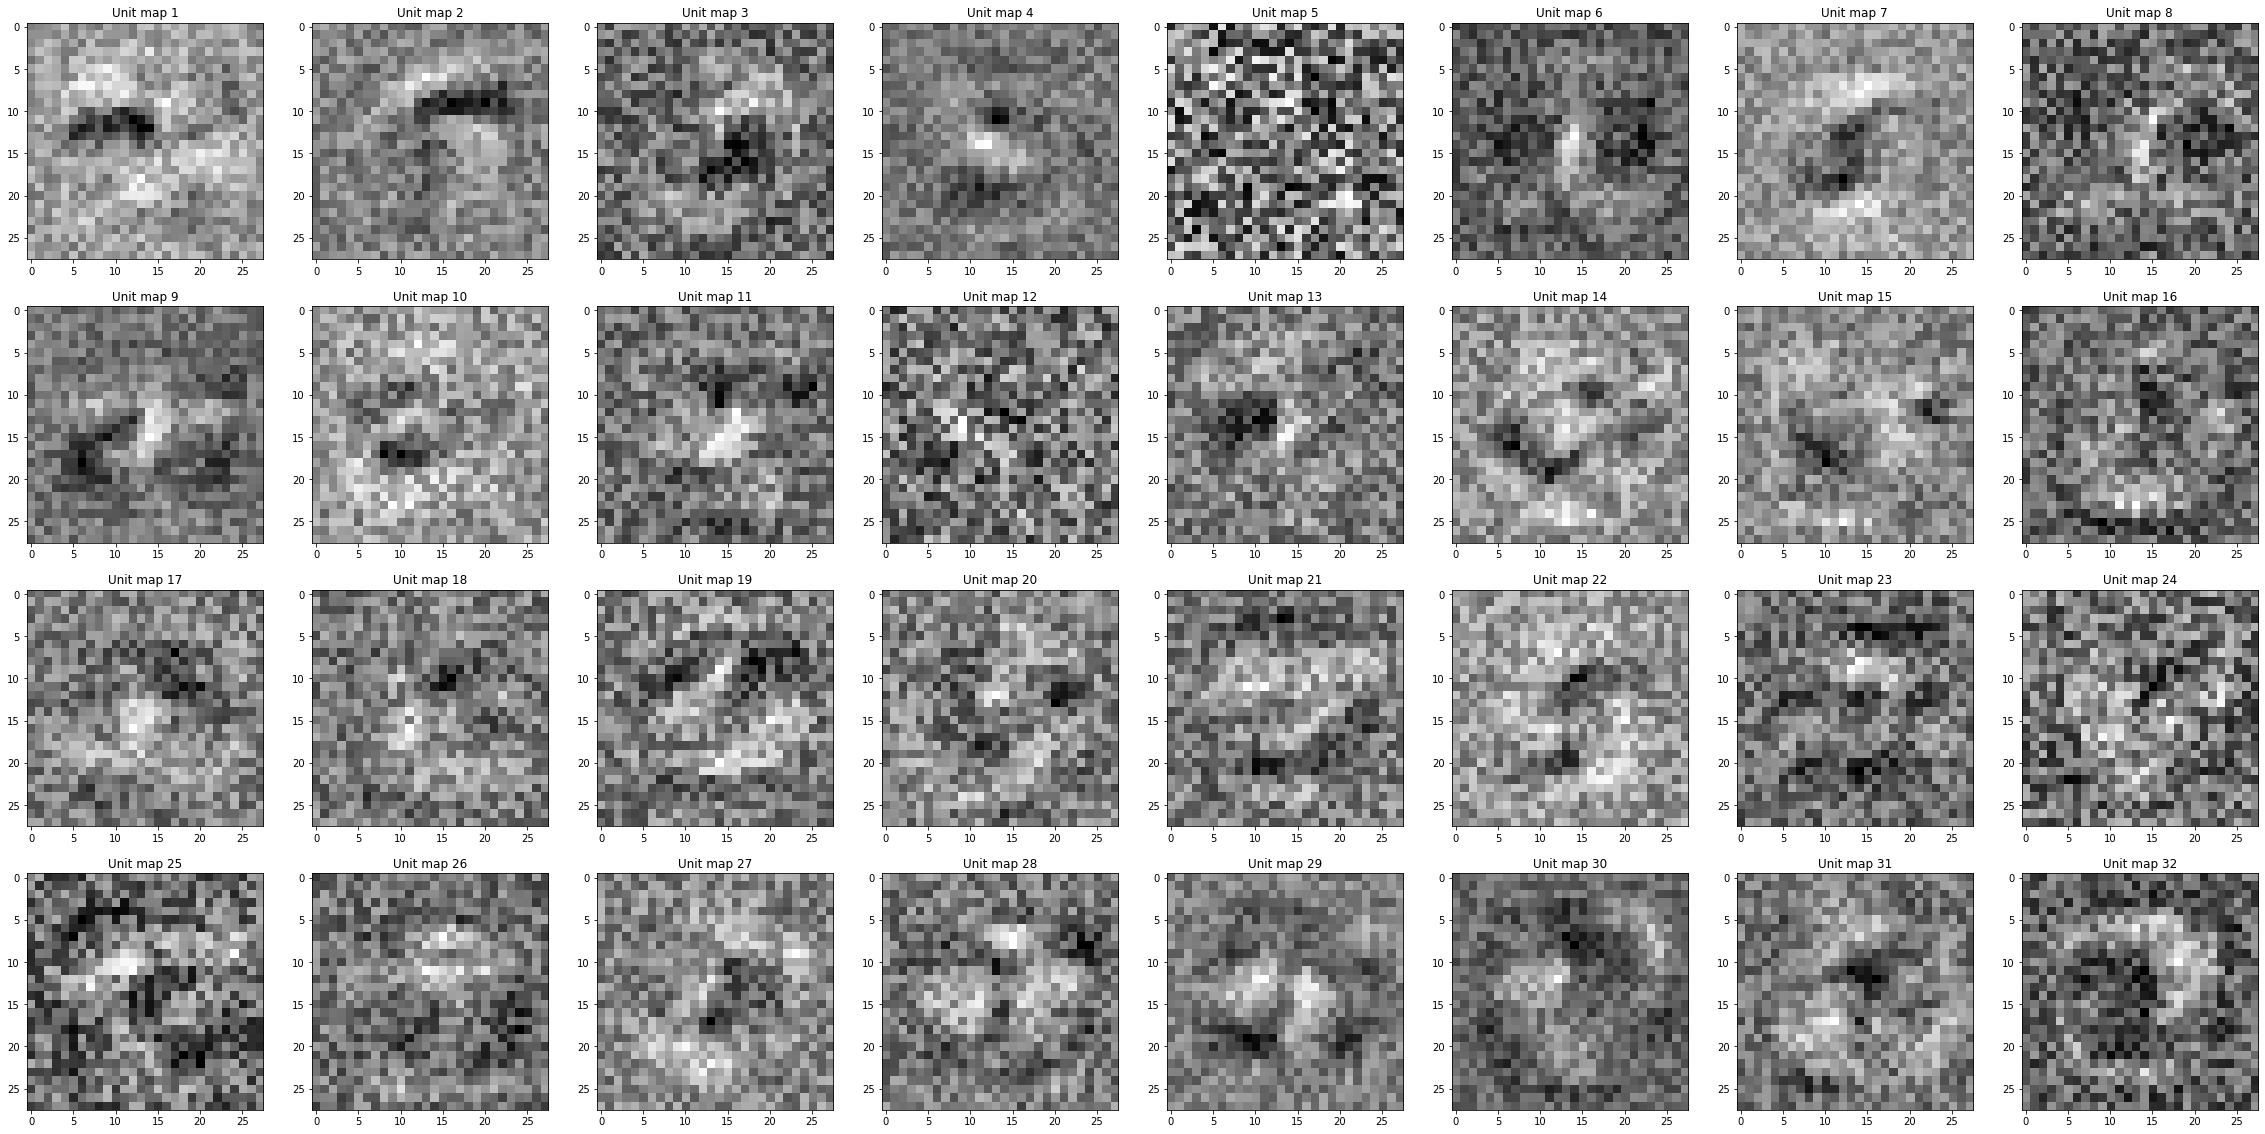

In [8]:
fig, axs = plt.subplots(4,8,figsize=(40, 20))
for _ in range(32):
    axs[_//8, _%8].imshow(np.array(model.layers[1].weights[0][:,_]).reshape(28,28), cmap="gray")
    axs[_//8, _%8].set_title("Unit map %i" % (_+1))
        
plt.show()

# Convolutional network

With images, convolutinonal layers are more efficient than Dense layers. We need to add a 4th dimension to the input data to pass it to a convolution layer. This correspond to the channel, a standard RGB image as 3, but our gray image only has one.

Two new layers:
```python
keras.layers.Conv2D(8, kernel_size=3, activation="relu"),
keras.layers.MaxPool2D(pool_size=2, padding="valid"),
```
The convolution applies the convolution filters and the maxpooling layers aggregates the feature maps on squared regions.

### Task 4 - Implement a convolutional neural network with 2 convolutional layers and train it on MNIST.

#### Note :
Tensorflow does not dealocate the weights of a network, even if you delete the model. To completely clear the weights of a model you need to call `keras.backend.clear_session()`.


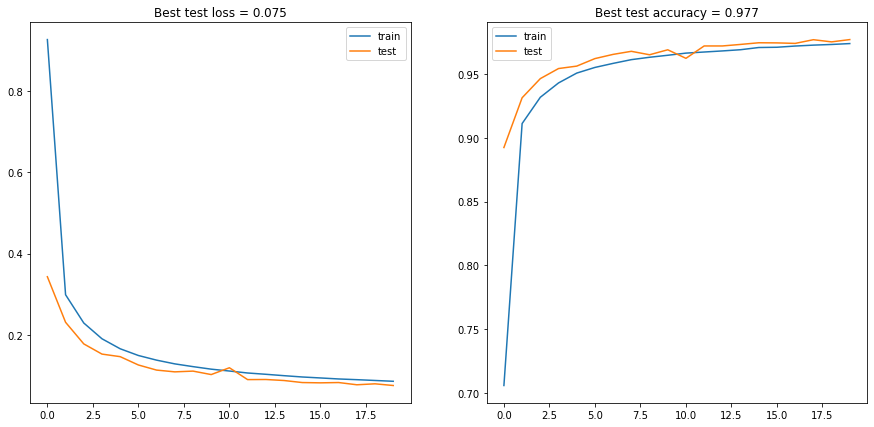

In [9]:
keras.backend.clear_session()

model = keras.Sequential(layers = [
    keras.layers.Reshape(target_shape=(28,28,1), input_shape=(28,28)),
    keras.layers.Conv2D(8, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    keras.layers.Conv2D(8, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test), verbose=0)

plot_history(history)

### Task 5 - vizualize the weights of the first convolution layer

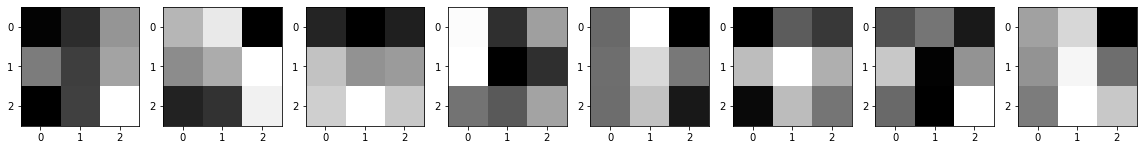

In [10]:
fig, axs = plt.subplots(1,8,figsize=(20,5))
for _ in range(8):
    axs[_].imshow(np.array(model.layers[1].weights[0][:,:,0,_]), cmap="gray")
        
plt.show()

### Task 6 - Using intermediate models, vizualize the outputs of the covolutions and max pooling for each layers.

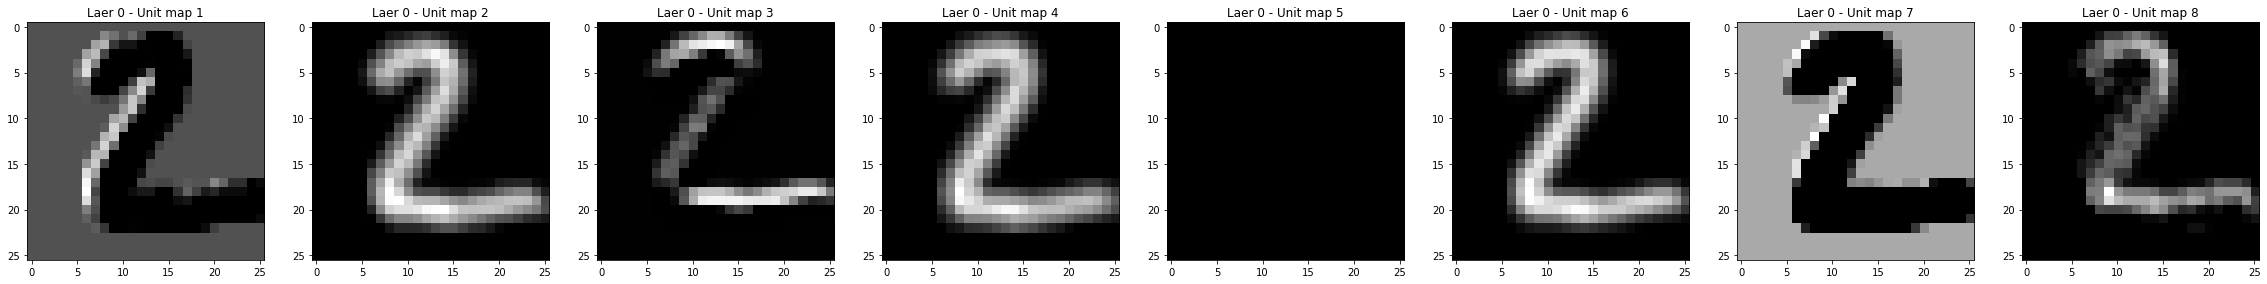

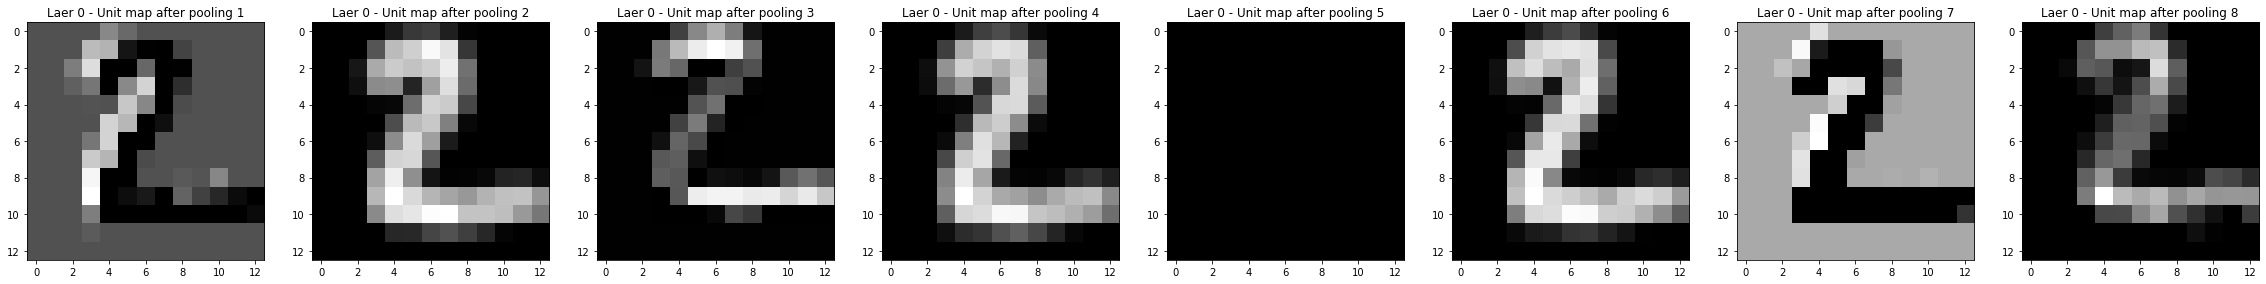

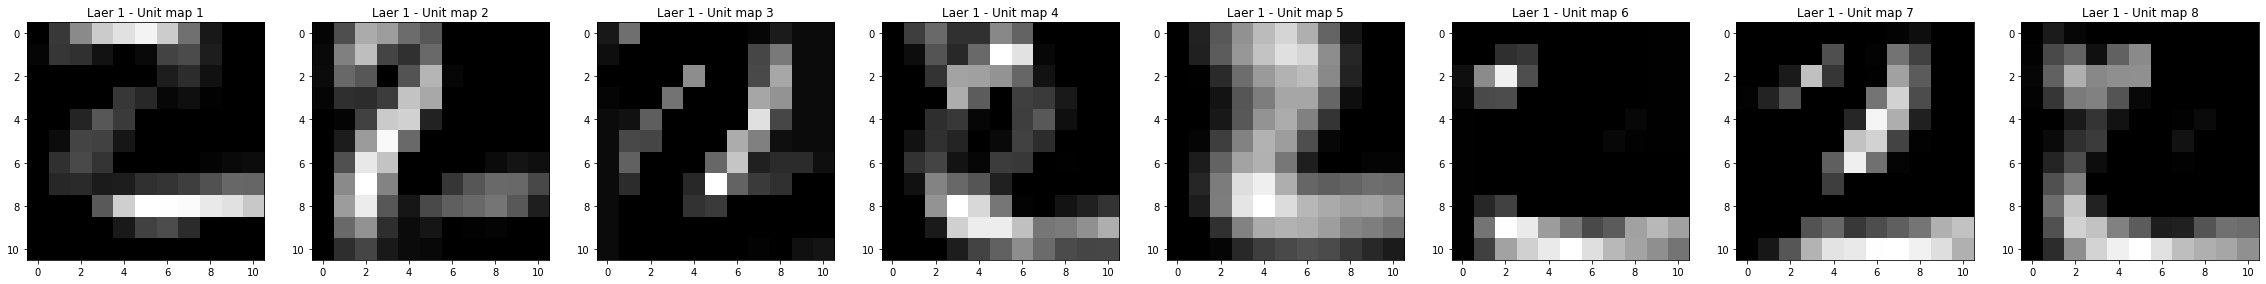

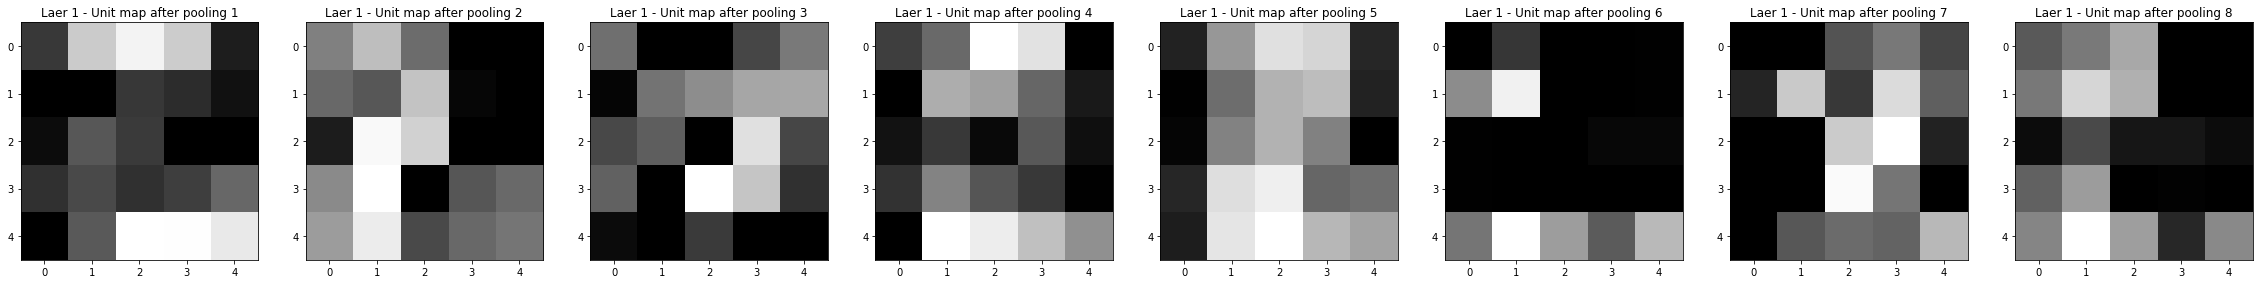

In [11]:
for layer in range(2):
    conv = keras.Model(inputs=model.input, outputs=model.layers[layer*2+1].output)
    pool = keras.Model(inputs=model.input, outputs=model.layers[layer*2+2].output)
    units = conv.predict(x_test)
    pooled = pool.predict(x_test)

    fig, axs = plt.subplots(1,8, figsize=(40,5))
    for _ in range(8):
        axs[_].imshow(np.array(units[1,:,:,_]), cmap="gray")
        axs[_].set_title("Laer %i - Unit map %i" % (layer, _+1))
        
    fig, axs = plt.subplots(1,8,figsize=(40,5))
    for _ in range(8):
        axs[_].imshow(np.array(pooled[1,:,:,_]), cmap="gray")
        axs[_].set_title("Laer %i - Unit map after pooling %i" % (layer, _+1))

    plt.show()

# Better optimization and Tensorboard

Up to now, we've let asside an important subject of deep learning, hyper-parameters tunning.

You can define an optimizer with the `optimizer` module of `Keras`:

```python
keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```

One of the most usefull features of `tensorflow`, `tensorboard`, is extremely easy to set up in `Keras`.
```python
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
```

Another common practice is to decrease the learning rate when the network stops learning.
This can be achierved with a callback:
```python
lrate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
```

### Task 7 - Play with those optimizers to get more suitable results.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 - 9s - loss: 0.1590 - accuracy: 0.9512 - val_loss: 0.0698 - val_accuracy: 0.9784
Epoch 2/20
60000/60000 - 8s - loss: 0.0715 - accuracy: 0.9783 - val_loss: 0.0595 - val_accuracy: 0.9806
Epoch 3/20
60000/60000 - 8s - loss: 0.0647 - accuracy: 0.9806 - val_loss: 0.0696 - val_accuracy: 0.9787
Epoch 4/20

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
60000/60000 - 8s - loss: 0.0586 - accuracy: 0.9825 - val_loss: 0.0753 - val_accuracy: 0.9769
Epoch 5/20
60000/60000 - 8s - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0409 - val_accuracy: 0.9873
Epoch 6/20
60000/60000 - 8s - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 7/20
60000/60000 - 8s - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0404 - val_accuracy: 0.9882
Epoch 8/20
60000/60000 - 8s - loss: 0.0265 - accuracy: 0.9922 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 9/20
60000/60000 - 8s - loss: 0

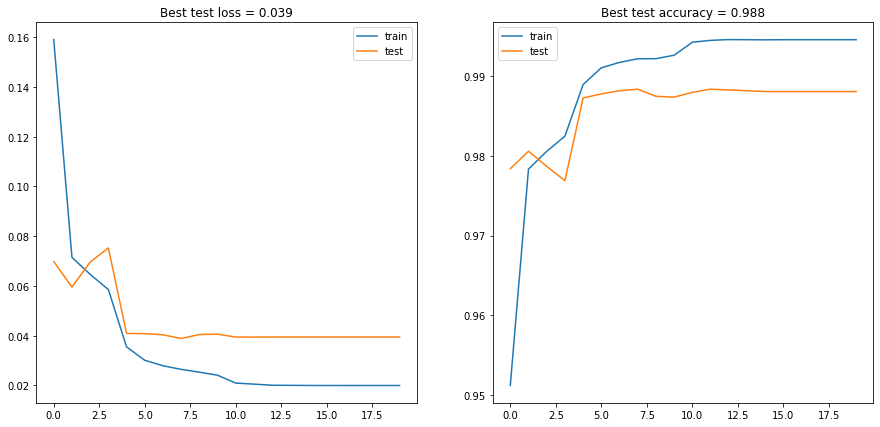

In [12]:
keras.backend.clear_session()

logdir = "logs/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.Sequential(layers = [
    keras.layers.Reshape(target_shape=(28,28,1), input_shape=(28,28)),
    keras.layers.Conv2D(8, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    keras.layers.Conv2D(8, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

optim = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lrate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.1, patience=2, verbose=1)
                                            
history = model.fit(x_train, y_train, batch_size=64, epochs=20, 
                    validation_data=(x_test, y_test), verbose=2, 
                    callbacks=[lrate, tensorboard_callback])

plot_history(history)

You can now visualize your network and metrics with tensorboard. If you dont have it install it with ``` pip install tensorboard
``` and then run it with ```tensorboard --logdir logs```